In [2]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt

# datasets

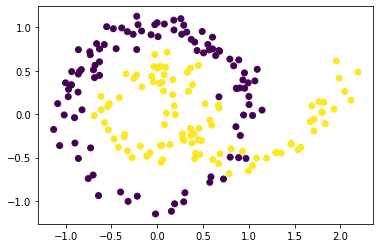

In [3]:
datasets = [make_moons(n_samples=100, noise=0.1), make_circles(n_samples=100, noise=0.1, factor=0.5)]
# datasets = [make_circles(n_samples=100, noise=0.1, factor=0.5)]
X = np.concatenate([x for x, _ in datasets])
Y = np.concatenate([y for _, y in datasets])
Y[Y==0] = -1
plt.scatter(X[:,0], X[:,1], c=Y)

# kernel

In [5]:
def linear_kernel(x, z):
    # x.shape: N * p, z.shape: N * p
    return (x[:, None, :] * z[None, :, :]).sum(-1)

def poly_kernel(x, z):
    # x.shape: N * p, z.shape: N * p
    p = 2
    return ((x[:, None, :] * z[None, :, :]).sum(-1) + 1) ** p

def rbf_kernel(x, z):
    # x.shape: N * p, z.shape: N * p
    var = 1
    return (2 * np.pi) ** (-x.shape[1] / 2) * np.exp(-((x[:, None, :] - z[None, :, :]) ** 2).sum(-1) / (2 * var))


# SVM

SVM classfier
- Parameters
  - kernel: kernel function $K(x, z)$
  - C: constrain $C$
- Fit
  - Given $N$ data: features $X=[x_1, x_2, ..., x_N]$, labels $Y=[y_1, y_2, ..., y_N], y_i \in \{-1, 1\}, i=1, 2, ..,,N$ 
  - SVM classfiers try to map features $x_i$ to $\phi(x_i)$ and fit the linear classifier based on those new features by maxing margin
  $$\min_{w, b} \frac{1}{2} w^T w + \sum_{i=1}^N \xi_i $$
  $$\mathrm{s.t. w^T \phi(x_i) + b \geq 1 - \xi_i}, i=1, 2, ..., N$$
  $$\xi_i \geq, i=1, 2, ..., N$$
  - SVM use the kernel trick and dual theory to optimize the objective above by those steps below
  1. Solve the dual problem with dual variables $\alpha$ <!-- $\alpha_i, i=1, 2, ..., N$ -->
  <!-- $$\min_{\alpha}\frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^N \alpha_i$$ -->
  <!-- $$\mathrm{s.t.} \sum_{i=1}^N \alpha_i y_i = 0$$ -->
  <!-- $$0 \leq \alpha_i \leq C, i=1, 2, ..., N$$ -->
  $$\min_{\alpha}\frac{1}{2} \alpha^T K^{X,Y} \alpha - \mathbb{1}_{N}^T \alpha$$
  $$y^T \alpha = 0$$
  $$\mathbb{0}_N \leq \alpha \leq C \mathbb{1}_N$$
  where $K^{X,Y}$ is a matrix with $N \times N$ size and $K_{i,j}^{X,Y} = y_i K(x_i, x_j) y_j$, $\mathbb{0}_N$, $\mathbb{1}_N$ are column vectors of length $N$ and all elements are 0 and 1, respectively
  2. For the optimal solution $\alpha^*$ <!-- $\alpha_i^{*}, i=1, 2, ..., N$ -->, chooses one that satisfy $0 < \alpha_j^{*} < C$, leading to the optimal $b^*$ 
  <!-- $$b^* = y_j - \sum_{i=1}^N \alpha_i^* y_i K(x_i, x_j)$$ -->
  $$b^* = y_j - \alpha^{*T} K^{X,Y} e_j$$
  where $e_j$ is a column vector with all elements are 0 except 1 in $j$-th element
- Predict
  - After fitting, we get the optimal $\alpha_i^*, i=1, 2, ..., N$ and $b^*$, then the decision function will be
  <!-- $$f(x) = \text{sign}(\sum_{i=1}^N \alpha_i^* y_i K(x_i, x) + b^*)$$ -->
  $$f(x) = \text{sign}(\alpha^{*T} K^{X,Y,x} + b^*)$$
  where $K^{X,Y,x}$ is a column vector of length $N$ with $K^{X,Y,x}_i = y_i K(x_i, x)$


Active-Set method to solve the dual problem

Let $A$ is a matrix with size $(1 + 2N) \times N$, and its row $A_i$
$$ A_i = \begin{cases}
y^T & \text{if } i = 0 \\
e_i & \text{if } i \in {1, 2, ..., N} \\
-e_{i-N} & \text{if } i \in {1 + N, 2 + N, ..., 2N} 
\end{cases} $$

and $c$ is a column vector with size $(1 + 2N)$, and its element $c_i$
$$ c_i = \begin{cases}
0 & \text{if } i \in {0, 1, 2, ..., N} \\
-C & \text{if } i \in {1 + N, 2 + N, ..., 2N}
\end{cases} $$


1. Set initial feasible solution $\alpha^{(0)} = 0$, initial active set $S^{(0)} = \{0, 1, ..., N\}$
2. Iteration
   - 2.1. for the active set $S^{(k)}$ and feasible $\alpha^{(k)}$, solve the problem w.r.t $d$
       $$\min_{d} \frac{1}{2} (\alpha^{(k)} + d)^T K^{X,Y} (\alpha^{(k)} + d) - \mathbb{1}_N^T (\alpha^{(k)} + d) = \min_{d} \frac{1}{2} d^T K^{X,Y} d + (\alpha^{(k)T} K^{X,Y} - \mathbb{1}_N)^T d$$
       $$A(S^{(k)}) d = 0$$
       where $A(S^{(k)})$ is a sub matrix of $A$ with rows from $S^{(k)}$
       by solving unconstrained optimization problem through Lagrange equation with Lagrange varible $\beta$
       $$ \min_{d} \frac{1}{2} d^T K^{X,Y} d + (\alpha^{(k)T} K^{X,Y} - \mathbb{1}_N)^T d + \beta^T A(S^{(k)}) d $$
   - 2.2. for the solution $d^{(k)}$ and $\beta^{(k)}$
     - if $d^{(k)} = 0$ and $\beta^{(k)} \geq 0$, then stop and return $\alpha^{*T} = \alpha^{(k)}$
     - if $d^{(k)} = 0$ and $\beta^{(k)}_j < 0$ at least for some $j$, then update $\alpha^{(k + 1)} = \alpha^{(k)}$ and $S^{(k + 1)} = S^{(k)} - \{i^{(k)}\}$, where $i^{(k)} = \min_{i \in S^{(k)} - \{0\}} \beta_i^{(k)}$
     - else ($d^* \neq 0$), set $\lambda^{(k)} = \min\big\{1, \min_{i \not\in S^{(k)}, A_i^T d* < 0)} \frac{b_i - A_i \alpha^{(k)}}{A_i d^{(k)}} \big\}$, and update $\alpha^{(k + 1)} = \alpha^{(k)} + \lambda^{(k)} d^{(k)}$
       - if $\lambda_k = 1$, set $S^{(k + 1)} = S^{(k)}$
       - else update $S^{(k + 1)} = S^{(k)} \cup \{j\}$, where $j \not\in S^{(k)}$ and $A_j(\alpha^{(k)} + \lambda^{(k)} d^{(k)}) = c_j$


In [16]:
class SVMClassifier:
    def __init__(self, kernel, max_step=1000):
        self.kernel = kernel
#         self.C = C
        self.max_step = max_step
    
    def _solve_opt_with_active_set(self, K, A, alpha, N):
        eps = 1e-8
        g = K @ alpha - np.ones(N).T
        Q, R = np.linalg.qr(A.T, mode="complete")
        na = A.shape[0]
        Q1, Q2 = Q[:,:na], Q[:,na:]
        R = R[:na,:]
        K_ = Q2.T @ K @ Q2
        g_ = Q2.T @ g
        
        u, s, vt = np.linalg.svd(K_)
        s_inv = np.array(s)
        s_inv[s >= eps] = 1.0 / s[s >= eps]
        K_pinv = vt.T @ np.diag(s_inv) @ u.T
        
        v = -K_pinv @ g_
        d = Q2 @ v
        beta = np.linalg.inv(R) @ Q1.T @ (K @ d + g)
        return d, beta
    
    
    def fit(self, X, Y):
        # X shape: N * p, Y shape: N
        N = len(Y)
        eps = 1e-5
        
        ## find first feasible solution
        for i in range(N-1):
            if Y[i] + Y[i+1] == 0: 
                break
        alpha = np.zeros(N)
#         alpha[i] = 1 / 2 * self.C
#         alpha[i + 1] = 1 / 2 * self.C
#         S = [0] + list(range(1, i + 1)) + list(range(i + 3, N + 1))
        alpha[i] = 1
        alpha[i + 1] = 1
        S = [0] + list(range(1, i + 1)) + list(range(i + 3, N + 1))
        
        
        K = Y[:, None] * Y[None, :] * self.kernel(X, X)
#         A = np.concatenate([Y[None, :], np.eye(N), -np.eye(N)])
#         c = np.concatenate([np.zeros(N + 1), -self.C * np.ones(N)])
        A = np.concatenate([Y[None, :], np.eye(N)])
        c = np.concatenate([np.zeros(N + 1)])
        
        d, beta = self._solve_opt_with_active_set(K, A[S, :], alpha, N)
        
        step = 0
        while step < self.max_step:
            if np.linalg.norm(d) < eps:
                if all(beta >= 0):
                    break
                else:
                    idx = np.argmin(beta) 
                    S = S[:idx] + S[idx+1:]
            else:
#                 T = [i for i in range(2 * N + 1) if i not in S]
                T = [i for i in range(N + 1) if i not in S]
                gap = (c[T] - A[T,:] @ alpha) / (A[T,:] @ d)
#                 print(gap)
#                 assert all(gap > -1)
                idx = np.argmin(gap)
                if  gap[idx] < 1:
                    S = S + [idx]
                alpha = alpha + min(gap[idx], 1) * d
            step = step + 1
        
        self.alpha = alpha
#         assert all(0 <= alpha <= self.C)
#         assert any(0 < alpha < self.C)
#         assert all(0 <= alpha)
#         assert any(0 < alpha)
        for i, v in enumerate(alpha):
#             if 0 < alpha < self.C:
            if 0 < alpha[i]:
                self.b = Y[i] + alpha @ K[:,i]
                break
        self.X = X
        self.Y = Y

    def predict(self, x):
        return self.alpha * self.kernel(x, self.X) @ (self.alpha * self.Y) + self.b 

## SVM with linear kernel

In [17]:
svc = SVMClassifier(linear_kernel)
svc.fit(X, Y)
y = svc.predict(X)

## SVM with poly kernel

In [18]:
svc = SVMClassifier(poly_kernel)
svc.fit(X, Y)
y = svc.predict(X)

## SVM with gaussian kernel

In [19]:
svc = SVMClassifier(rbf_kernel)
svc.fit(X, Y)
y = svc.predict(X)